<center><h2>Artificial and Computational Intelligence</h2></center>

## Problem Statement

Ravichandran Ashwin is one of the most successful test bowlers from India claiming more than
350 international wickets. He has been spearheading the spin attack for the Indian test team since his
debut in November 2011 and is expected to make a dash to 400 wickets in the upcoming test series with
New Zealand. However, some exciting new spinning prospects have also staked their claim for the test
team.
As a selector you are aware about non subcontinent pitches being non-spin friendly which
reduces the number of slots for spinners in the team. Being an ex-player, you also know how important
toss is in test matches since it dictates whether a team will bat first or not. The decision to bat or bowl
first can have significant import on the final outcome of a match.
You have decided to construct a Bayesian Network to help you with your conundrum and help
you with your decision on Ashwin’s selection for the upcoming tour.
Attached excel contains information on all test matches played by India since Ashwin’s debut in
2011. Use below variables as nodes for your Bayesian Network (Please note that below image provides
no information on conditionality between variables).

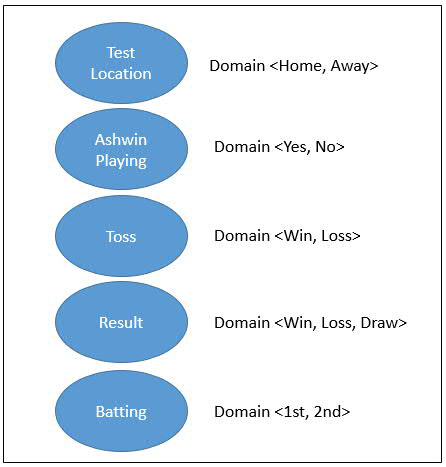

Implement Bayesian Networks and also learn to use the pomegranate library.

Create a bayesian network model which would help you predict the probability.

1) Create a function to calculate prior probability of any given variable. The function should read in
an array and output a dictionary of prior probability of each possible outcome.
e.g. {'A': 1/4, 'B': 1/2, 'C': 1/4}


2) Create a function to calculate conditional probability. The function should read in multiple
arrays and calculate the posterior probability of the last array wrt to previous arrays. For
example, if you pass arrays “Location” and “Ashwin Playing” the output should be
[[ 'home', 'Y', 0.xx ],
[ 'home', 'N', 0.xx ],
[ 'away', 'Y', 0.xx ],
[ 'away', 'N', 0.xx ]]


3) Use the functions created above and python’s pomegranate library to define conditionality
between variables to create Bayesian Network. Refer this excellent tutorial on how to use
pomegranate to create Bayesian Networks.
https://github.com/jmschrei/pomegranate/blob/master/tutorials/B_Model_Tutorial_4_Bayesian_Networks.ipynb


4) Use the Bayesian Network model created to calculate the probability of:
a. India winning, batting 2nd, Ashwin playing
b. India winning, batting 2nd, Ashwin not playing
c. India losing, batting 2nd, Ashwin playing
d. India losing, batting 2nd, Ashwin not playing


### What is a Bayesian Network ?

A Bayesian network, Bayes network, belief network, decision network, Bayes(ian) model or probabilistic directed acyclic graphical model is a probabilistic graphical model (a type of statistical model) that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. Given symptoms, the network can be used to compute the probabilities of the presence of various diseases. 

### Dataset

Dataset is attached in github. 

#### Dataset Description
##### Sample Tuple

Y	won	5wickets	lost	2nd	vWest_Indies	Home	6-Nov-11

##### Explanation
- The first column represents if Ashwin was in the playing 11 or not. 
- The second column represents the Result of the match . win indicates India won the match.
- The third column represents the Margin of victory / losss.
- The fourth column represents the results of the toss. won indicates India won the toss. 
- The fifth column represents the batting order. If India batted 1st or 2nd. 
- The sixth column represents the opponent.
- The seventh column represents the location of the match. If the match was held in Home(India) or away. 
- The last column represents the start date of the match.


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pomegranate import *

## Read Data

In [2]:
df = pd.read_excel(r'.\India_Test_Stats.xlsx', keep_default_na=True, na_values=['?'])

## Pre-process data (Whatever you feel might be required)

In [3]:
#Converting to lower case
from pandas.api.types import is_string_dtype

for col in df.columns: 
    if is_string_dtype(df[col]):
       df[col]=df[col].str.lower()

## Data Description 

In [4]:
#Identify columns with missing values
missing_val_columns_before=df.columns[df.isnull().any()]

for col in missing_val_columns_before: 
    print ("\n"+col+"\n-----")
    print(df[col].value_counts(dropna=False))
    
print("Head:\n***************\n%s" %(df.head(5)))
print("\n\n")
print("Summary:\n***************\n%s" %(df.astype('str').describe().transpose()))

Head:
***************
  Ashwin Result          Margin  Toss  Bat     Opposition Location Start Date
0      y    won       5 wickets  lost  2nd  v west indies     home 2011-11-06
1      y    won  inns & 15 runs   won  1st  v west indies     home 2011-11-14
2      y   draw               -  lost  2nd  v west indies     home 2011-11-22
3      y   lost        122 runs  lost  2nd    v australia     away 2011-12-26
4      y   lost  inns & 68 runs   won  1st    v australia     away 2012-01-03



Summary:
***************
           count unique          top freq
Ashwin        85      2            y   70
Result        85      3          won   47
Margin        85     61            -   16
Toss          85      2         lost   45
Bat           85      2          1st   46
Opposition    85      8  v australia   20
Location      85      2         home   43
Start Date    85     85   2012-11-15    1


## Define Methods

### Method to convert panda's multi-index to double-array

In [5]:
def convert_multi_index_data_to_numpy(grouped):
    index_np=None
    for each_list in grouped.index.to_numpy():
        if index_np is None:
            index_np=np.array(each_list)
        else:
            index_np=np.concatenate([index_np, np.array(each_list)], axis=0)

    values_np=grouped.to_numpy()
    m=np.shape(values_np)[0]
    n=int(len(index_np)/m)
    final_np=np.concatenate([index_np.reshape(m,n),values_np],axis=1 )
    return final_np

### Method to convert to probability measure

In [6]:
def convert_to_probability_measure(numpy_arr):
    df= pd.DataFrame(numpy_arr)
    last_column_name=len(df.columns)-1
    df[last_column_name]=pd.to_numeric(df[last_column_name]) #Convert last column to numeric

    group_by_cols=df.columns.to_list().copy()
    group_by_cols.pop()
    group_by_cols.pop()
    group_as_dict=df.groupby(group_by_cols)[last_column_name].sum().to_dict()
    mod_group_as_dict={}
    for key in group_as_dict:
        if type(key) == str:
            mod_group_as_dict[key]=group_as_dict[key]
        else:
            mod_group_as_dict[str(key)]=group_as_dict[key]

    for index, row in df.iterrows():
        key=row[0]
        if len(group_by_cols)>1:
            key=str(tuple(row[group_by_cols].to_list()))
        
        # Update each cell to probability value by dividing it by group's total
        df.loc[index,last_column_name]=row[last_column_name]/mod_group_as_dict[key]        

    return df.to_numpy()

### Method to build a prior probability for column

In [11]:
def get_prior_prob_by_col_name(col_name, df):
    col_df=df[col_name]
    total=col_df.count()
    group_as_dict=col_df.value_counts().to_dict()
        
    # Convert the frequency to probability measure
    for val in group_as_dict:
        group_as_dict[val]=group_as_dict[val]/total
    
    # group_as_dict represents prior probability
    return group_as_dict

### Method to get conditional probability

In [14]:
def get_conditional_prob_by_col_name(col_name, df, conditional_col_names):
    gr_by_cols=conditional_col_names.copy()
    gr_by_cols.append(col_name)

    grouped=df.groupby(gr_by_cols)[col_name].count()
    grouped=grouped.to_frame()
    group_as_num_array=convert_multi_index_data_to_numpy(grouped)
    if col_name=='Ashwin':
        group_as_num_array = np.append(group_as_num_array, np.array([['home','n',0]]), axis=0)
    if col_name=='Result': 
        group_as_num_array = np.append(group_as_num_array, np.array([['n', '2nd', 'won', 0]]), axis=0)
        
        
    group_as_num_array=convert_to_probability_measure(group_as_num_array)
    return group_as_num_array

## Construction of Bayesian Network

In [17]:
#Define prior probabilities
TOSS_DIST_DATA=get_prior_prob_by_col_name('Toss', df)
LOCATION_DIST_DATA=get_prior_prob_by_col_name('Location', df)

#Define conditional probabilities
BATTING_CPT_TOSS_DATA=get_conditional_prob_by_col_name('Bat', df, ['Toss'])
ASHWIN_CPT_LOC_DATA=get_conditional_prob_by_col_name('Ashwin', df, ['Location'])
RESULT_CPT_ASHWIN_AND_BATTING_DATA=get_conditional_prob_by_col_name('Result', df, ['Ashwin','Bat'])

#Define the probability tables using Pomegranate lib
toss_prob_table = DiscreteDistribution(TOSS_DIST_DATA)
batting_cond_prob_table = ConditionalProbabilityTable(BATTING_CPT_TOSS_DATA, [toss_prob_table])

location_prob_table = DiscreteDistribution(LOCATION_DIST_DATA)
ashwin_cond_prob_table = ConditionalProbabilityTable(ASHWIN_CPT_LOC_DATA, [location_prob_table])

result_cond_prob_table = ConditionalProbabilityTable(RESULT_CPT_ASHWIN_AND_BATTING_DATA, [ashwin_cond_prob_table, batting_cond_prob_table])

#Define the correspoding states using Pomegranate lib
toss_state = State(toss_prob_table, name="Toss")
batting_state = State(batting_cond_prob_table, name="Batting")
location_state = State(location_prob_table, name="Location")
ashwin_state = State(ashwin_cond_prob_table, name="Ashwin")
result_state = State(result_cond_prob_table, name="Result")

#Define the model, add States, and add Edges (using Pomegranate lib)
model = BayesianNetwork("Spinning the Bayes Net")
model.add_states(result_state, batting_state, ashwin_state, location_state, toss_state )

#Edge: batting depends on toss
model.add_edge(toss_state, batting_state)
#Edge: Ashwin's selection depends on location
model.add_edge(location_state, ashwin_state)
#Edge: Result of a match depends on batting first and Ashwin's selection
model.add_edge(ashwin_state, result_state)
model.add_edge(batting_state, result_state)

#Finalize the topology of the model, so that we can ask probabilities of various events
model.bake()


## Solution for Part: 1
### Refer to the impementation @ [Method to build a prior probability for column](#Method-to-build-a-prior-probability-for-column)

In [18]:
print("Prior probability for Toss:\n\t%s" %(get_prior_prob_by_col_name('Toss', df)))
print("\n\nPrior probability for Location:\n\t%s" %(get_prior_prob_by_col_name('Location', df)))

Prior probability for Toss:
	{'lost': 0.5294117647058824, 'won': 0.47058823529411764}


Prior probability for Location:
	{'home': 0.5058823529411764, 'away': 0.49411764705882355}


## Solution for Part: 2
### Refer to the impementation @ [Method to get conditional probability](#Method-to-get-conditional-probability)

In [19]:
print("Conditional probability of Ashwin given Location:\n%s" %(get_conditional_prob_by_col_name('Ashwin', df, ['Location'])))
print("\n\nConditional probability of Batting given Toss:\n%s" %(get_conditional_prob_by_col_name('Bat', df, ['Toss'])))

Conditional probability of Ashwin given Location:
[['away' 'n' 0.35714285714285715]
 ['away' 'y' 0.6428571428571429]
 ['home' 'y' 1.0]
 ['home' 'n' 0.0]]


Conditional probability of Batting given Toss:
[['lost' '1st' 0.2222222222222222]
 ['lost' '2nd' 0.7777777777777778]
 ['won' '1st' 0.9]
 ['won' '2nd' 0.1]]


## Solution of Part 3
### Refer to the impementation @ [Construction of Bayesian Network](#Construction-of-Bayesian-Network)

In [20]:
print("Model: \n\n%s" %(model))

Model: 

Spinning the Bayes Net:{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "name" : "ConditionalProbabilityTable",
        "table" : [
            [
                "y",
                "2nd",
                "lost",
                "0.24242424242424243"
            ],
            [
                "y",
                "2nd",
                "draw",
                "0.2727272727272727"
            ],
            [
                "y",
                "2nd",
                "won",
                "0.48484848484848486"
            ],
            [
                "y",
                "1st",
                "lost",
                "0.1891891891891892"
            ],
            [
                "y",
                "1st",
                "draw",
                "0.10810810810810814"
            ],
            [
                "y",
                "1st",
                "won",
                "0.7027027027027027"
            ],
            [

## Solution for Part 4

In [21]:
# a)India winning, batting 2nd, Ashwin playing

#Prob[Result=Winning, Batting=2nd, Ashwin_Playing=Y, location=Any, Toss=Any]
resulta=model.predict_proba(['won','2nd','y', None,None ]) 
print("A. Probability of India winning, batting 2nd, Ashwin playing is: \n\n%s\n\n\n" %(resulta))


# b) India winning, batting 2nd, Ashwin not playing

#Prob[Result=Winning, Batting=2nd, Ashwin_Playing=N, location=Any, Toss=Any]
resultb=model.predict_proba(['won','2nd','n', None,None ]) 
print("B. Probability of India winning, batting 2nd, Ashwin not playing is: \n\n%s\n\n\n" %(resultb))


# c) India losing, batting 2nd, Ashwin playing

#Prob[Result=Losing, Batting=2nd, Ashwin_Playing=Y, location=Any, Toss=Any]
resultc=model.predict_proba(['lost','2nd','y', None,None ]) 
print("C. Probability of India losing, batting 2nd, Ashwin playing is: \n\n%s\n\n\n" %(resultc))


# d) India losing, batting 2nd, Ashwin not playing

#Prob[Result=Losing, Batting=2nd, Ashwin_Playing=n, location=Any, Toss=Any]
resultd=model.predict_proba(['lost','2nd','n', None,None ]) 
print("D. Probability of India losing, batting 2nd, Ashwin not playing is: \n\n%s\n\n" %(resultd))


A. Probability of India winning, batting 2nd, Ashwin playing is: 

['won' '2nd' 'y'
 {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "home" :0.6142857142857142,
            "away" :0.3857142857142858
        }
    ],
    "frozen" :false
}
 {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "lost" :0.8974358974358972,
            "won" :0.10256410256410274
        }
    ],
    "frozen" :false
}]



B. Probability of India winning, batting 2nd, Ashwin not playing is: 

['won' '2nd' 'n'
 {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "home" :0.5058823529411764,
            "away" :0.49411764705882366
        }
    ],
    "frozen" :false
}
 {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
       

## Final Inference

In [24]:
final_inference=model.predict_proba({}) 
print("Final inference:\n\n%s" %(final_inference))

Final inference:

[{
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "lost" :0.264614630358575,
            "draw" :0.18594974338918982,
            "won" :0.5494356262522351
        }
    ],
    "frozen" :false
}
 {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "2nd" :0.4588235294117648,
            "1st" :0.5411764705882353
        }
    ],
    "frozen" :false
}
 {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "y" :0.8235294117647056,
            "n" :0.17647058823529435
        }
    ],
    "frozen" :false
}
 {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "home" :0.5058823529411764,
            "away" :0.49411764705882355
        }
    ],
    "frozen" :false
}
 {
  